In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings(action='once')

In [3]:
#Errors
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(list(np.array(forecast) - np.array(actual)))/np.abs(actual))  # MAPE
    me = np.mean(list(np.array(forecast) - np.array(actual)))             # ME
    mae = np.mean(np.abs(list(np.array(forecast) - np.array(actual))))    # MAE
    mpe = np.mean((list(np.array(forecast) - np.array(actual)))/np.array(actual))   # MPE
    rmse = np.mean(list(np.array(list(np.array(forecast) - np.array(actual)))**2))**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'corr':corr})

In [4]:
def grid_search(order,s_order, seasons, error):
    '''
    Grid search process to find optimal solution within a list of given parameters
    '''
    best_e=float('inf')
    for o in order:
        print(o)
        for s_o in s_order:
            for s in seasons:
                try:
                    model_SARIMA= SARIMAX(train,order=o, seasonal_order=s_o+(s,), freq='MS')
                    model_SARIMA_fit=model_SARIMA.fit(disp=0)
                    predictionSAR = model_SARIMA_fit.forecast(test_v)
                    errors=forecast_accuracy(predictionSAR.values.tolist(),test.bmb.tolist())
                    e = errors[error]
                    if e<best_e:
                        opt_params = [o,s_o+(s,)]
                        best_e=e
                        print(opt_params, best_e)
                except:
                    print("Error")
                    
    print(best_e)
    return opt_params

In [5]:
bmb_serie = pd.read_csv(r"..\Datos\canasta_basica_serie.csv",index_col=0)

In [6]:
bmb_serie.columns = ['bmb']

<AxesSubplot:>

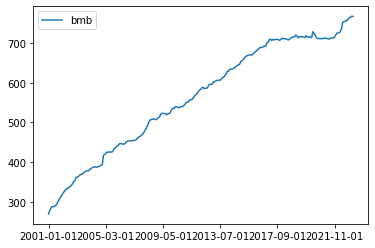

In [7]:
bmb_serie.plot()

In [8]:
test_v =12
valid_v = 3


train= bmb_serie[:-(test_v+valid_v)]
test = bmb_serie[-(test_v+valid_v):-valid_v]
validation = bmb_serie[-valid_v:]

In [9]:
print(train)

               bmb
2001-01-01  269.77
2001-02-01  278.02
2001-03-01  284.25
2001-04-01  288.45
2001-05-01  287.77
...            ...
2021-08-01  712.67
2021-09-01  712.85
2021-10-01  712.12
2021-11-01  715.31
2021-12-01  719.65

[252 rows x 1 columns]


C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


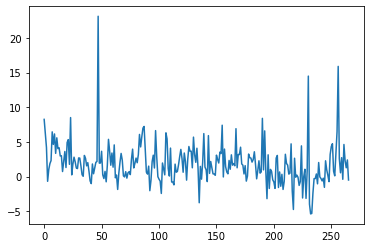

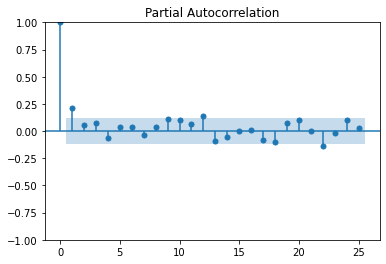

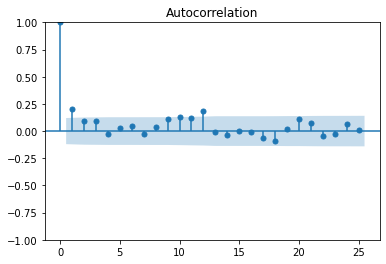

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
bmb_diff = [x[0] for x in (bmb_serie[1:].values-bmb_serie[:-1].values)]
plt.plot(bmb_diff)
plot_pacf(np.array(bmb_diff))
plot_acf(np.array(bmb_diff))
print('')

order1 = [(1,1,2)]

s_order1 = itertools.product([1,2,3,4,5],repeat=3)
seasons1 = [2,3,4,6,12]

opt_params = grid_search(order1,s_order1, seasons1, 'mae')

print(opt_params)

model_SARIMA= SARIMAX(train,order=opt_params[0], seasonal_order=opt_params[1])
model_SARIMA_fit=model_SARIMA.fit(disp=0)
predictionSAR = model_SARIMA_fit.forecast(test_v)

x=forecast_accuracy(predictionSAR.values.tolist(), test.bmb.tolist())
print(x)

In [11]:
model_SARIMA= SARIMAX(train,order=(1,1,2), seasonal_order=(1,2,1,3))

model_SARIMA_fit=model_SARIMA.fit(disp=0)
print(model_SARIMA_fit.aic)
predictionSAR = model_SARIMA_fit.predict(start=1,end=len(bmb_serie)-1)


x=forecast_accuracy(predictionSAR.values.tolist()[:-test_v-valid_v], train.bmb.tolist()[1:])
print(x)
xt=forecast_accuracy(predictionSAR.values.tolist()[-test_v-valid_v:-valid_v], test.bmb.tolist())
print(xt)
xv=forecast_accuracy(predictionSAR.values.tolist()[-valid_v:], validation.bmb.tolist())
print(xv)

C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


1298.444491450774
{'mape': 0.009211245704980754, 'me': 0.7043703991976866, 'mae': 3.695597858440196, 'mpe': 0.0026036809172073857, 'rmse': 17.329361503387528, 'corr': 0.9916943997728154}
{'mape': 0.006065239475518315, 'me': -1.9229119462924302, 'mae': 4.527564309764983, 'mpe': -0.002487337440479535, 'rmse': 5.35096453167084, 'corr': 0.954860091895554}
{'mape': 0.0026104603863258357, 'me': 2.0014424872495056, 'mae': 2.0014424872495056, 'mpe': 0.0026104603863258357, 'rmse': 2.8501121690185345, 'corr': 0.7741133969345712}


In [12]:
final_prediction = model_SARIMA_fit.forecast(24)[-9:]
np.savetxt(r'..\Datos\sarima_prediction.csv',final_prediction.values, fmt = '%f', delimiter=",")   